# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.stats import zmap
import torch
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec


# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

# Ke_path = cond_path / '22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200'
Ke_path = cond_path / '22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200'
ls_path = cond_path / '22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07'
ko_path = cond_path / '22-10-16_aLc1_line800_sticky55nm_kod.1-300'


# Style and graphing
from cond_char_style import cond_char_sty
plt.style.use(cond_char_sty)
marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')



Torch device: cuda


# Functions

In [2]:
def find_steady_state_ind(arr, avg_inv=(0,None)):
    """Find the first time an array reaches an average value given an interval
    to average over (usually the end of the array).

    Parameters
    ----------
    arr : _type_
        _description_
    avg_inv : tuple, optional
        _description_, by default (0,None)
    """
    arr = np.array(arr)
    avg = arr[avg_inv[0]:avg_inv[1]].mean()
    if avg > arr[0]:
        return (arr >= avg).nonzero()[0]
    return (arr <= avg).nonzero()[0][0]



# Collect and save analyzed data

In [3]:
def save_rog_data(run_path,
                    param_str, 
                    rog_avg_ind = -600,
                    ss_ind = 1,
                    end_ind = -1,
                    start_bead = 0,
                    end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'rog_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            rog_arrs = []
            clps_times = []
            avg_clps_rog_arr = []
            std_clps_rog_arr = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                rog = aa.calc_rad_of_gyration(com_arr)
                clps_ind = find_steady_state_ind(rog, [rog_avg_ind, None])
                rog_arrs += [rog.tolist()]
                clps_times += [time_arr[clps_ind]]
                avg_clps_rog_arr += [rog[clps_ind:].mean()]
                std_clps_rog_arr += [rog[clps_ind:].std()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in rog_arrs])
            rog_arrs = np.array([_[:min_length] for _ in rog_arrs])

            # Create dataset
            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  rog_arrs.mean(axis=0)[:, np.newaxis],
                                  rog_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = rog_arrs.shape[0]
            d_set.attrs['collapse_times'] = clps_times
            d_set.attrs['avg_collapse_rog'] = avg_clps_rog_arr
            d_set.attrs['std_collapse_rog'] = std_clps_rog_arr

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            

            for h5d in sd_h5_data_lst:
                h5d.close()


In [4]:
save_rog_data(Ke_path, param_str="Ke")

0it [00:00, ?it/s]

(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)


In [74]:
#save_rog_data(ls_path, param_str='Ls')

0it [00:00, ?it/s]

(4704, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)
(4800, 3)


In [76]:
#save_rog_data(ko_path, param_str='kod')

0it [00:00, ?it/s]

(4800, 3)
(4513, 3)
(4541, 3)
(4541, 3)
(4511, 3)
(4511, 3)
(4522, 3)
(4514, 3)


# Graphing

In [3]:
def graph_rog_collapse_ax(fig, ax, h5_path, 
                          colorbar_label='', 
                          ci_bound = .95,
                          label_str= '{}'):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            h5_data = h5d[pv]
            time_arr = h5_data[:,0]
            mean_rog_arr = h5_data[:,1]
            std_rog_arr = h5_data[:,2]

            _ = ax.plot(time_arr, mean_rog_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_rog_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_rog_arr - ci, mean_rog_arr + ci, 
                                color=colors[i], alpha=.25)

        _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
        # _ = ax.set_xlabel('Time (sec)')
        _ = ax.set_yscale('log')
        _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [4]:

def graph_time_collapse_ax(fig, ax, h5_path, 
                          colorbar_label='', ci_bound = .95,
                          pval_start_ind = 0, xlog=True):

    ax1 = ax.twinx()
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        pvals = [float(p) for p in param_vals]
        avg_clps_times_arr = []
        std_clps_times_arr = []
        rog_avg = []
        rog_std = []

        for i, pv in enumerate(param_vals):
            h5_data = h5d[pv]
            avg_clps_times_arr += [np.mean(h5_data.attrs['collapse_times'])]
            std_clps_times_arr += [np.std(h5_data.attrs['collapse_times'])]
            rog_avg += [np.mean(h5_data.attrs['avg_collapse_rog'])]
            rog_std += [np.std(h5_data.attrs['avg_collapse_rog'])]

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = ax.errorbar(pvals[pval_start_ind:], 
                    avg_clps_times_arr[pval_start_ind:], 
                    yerr=std_clps_times_arr[pval_start_ind:], 
                    color='tab:blue' , **marker_style)
        
    _ = ax.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = ax.set_yscale('log')
    if xlog:
        _ = ax.set_xscale('log')
    _ = ax.set_ylim(100, 1800)
    _ = ax.tick_params(axis='y', labelcolor='tab:blue')

    _ = ax1.errorbar(pvals[pval_start_ind:], rog_avg[pval_start_ind:], 
                     yerr=rog_std[pval_start_ind:], color='tab:orange', **marker_style)
    _ = ax1.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')
    # _ = axarr2.set_ylim(.1, .15)
    _ = ax1.tick_params(axis='y', labelcolor='tab:orange')
    _ = ax1.set_ylim(.0, .6)

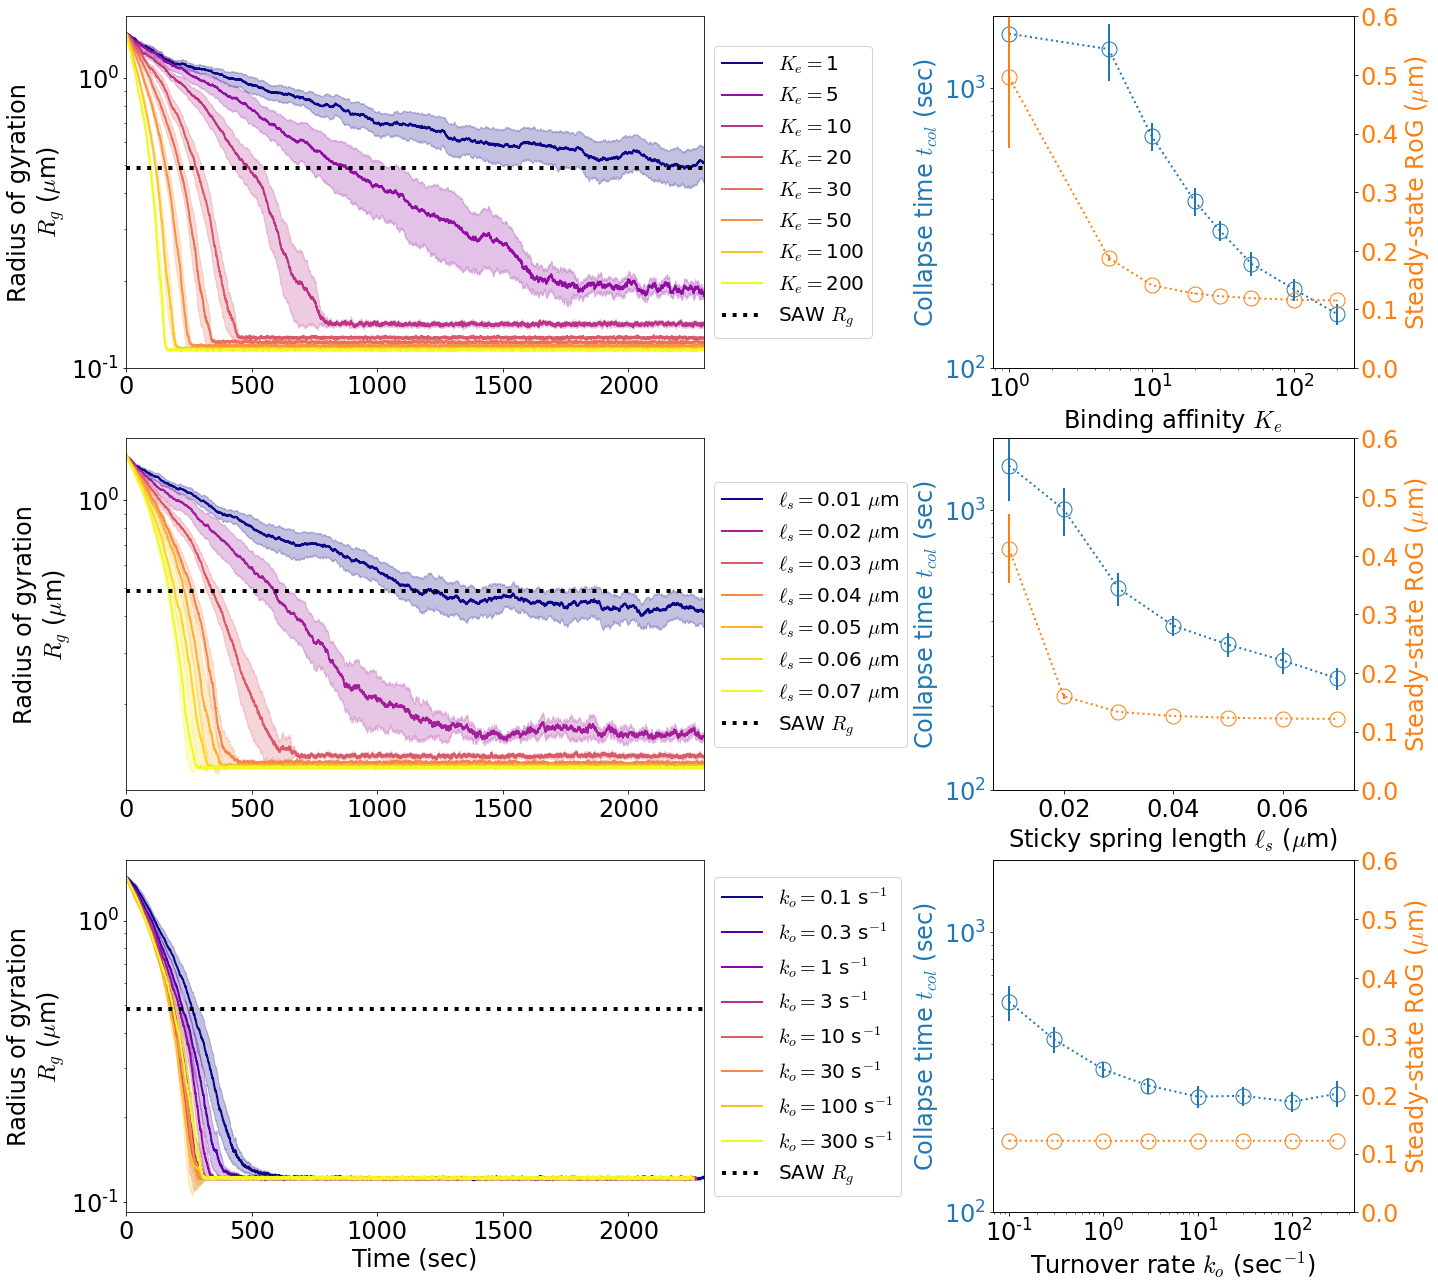

In [6]:
fig = plt.figure(figsize=(22,22), constrained_layout=True)
gs = GridSpec(3, 6, wspace=.5)

ax0 = fig.add_subplot(gs[0,:3])
graph_rog_collapse_ax(fig, ax0, Ke_path / 'analysis/rog_run_data.h5', label_str='$K_e = ${}')
ax1 = fig.add_subplot(gs[0,4:])
graph_time_collapse_ax(fig, ax1, Ke_path / 'analysis/rog_run_data.h5')
_ = ax1.set_xlabel('Binding affinity $K_e$')

ax2 = fig.add_subplot(gs[1,:3])
graph_rog_collapse_ax(fig, ax2, ls_path / 'analysis/rog_run_data.h5', label_str='$\ell_s = ${} $\mu$m')
ax3 = fig.add_subplot(gs[1,4:])
graph_time_collapse_ax(fig, ax3, ls_path / 'analysis/rog_run_data.h5', xlog=False)
_ = ax3.set_xlabel('Sticky spring length $\ell_s$ ($\mu$m)')

ax4 = fig.add_subplot(gs[2,:3])
graph_rog_collapse_ax(fig, ax4, ko_path / 'analysis/rog_run_data.h5', label_str='$k_o = ${} s$^{{-1}}$')
ax5 = fig.add_subplot(gs[2,4:])
graph_time_collapse_ax(fig, ax5, ko_path / 'analysis/rog_run_data.h5')
_ = ax4.set_xlabel('Time (sec)')
_ = ax5.set_xlabel('Turnover rate $k_o$ (sec$^{-1}$)')

for ax in (ax0, ax2, ax4):
    _ = ax.set_xlim(0, 2300)
    
# ax3.set_xlim(0, .8)

# Testing figures

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


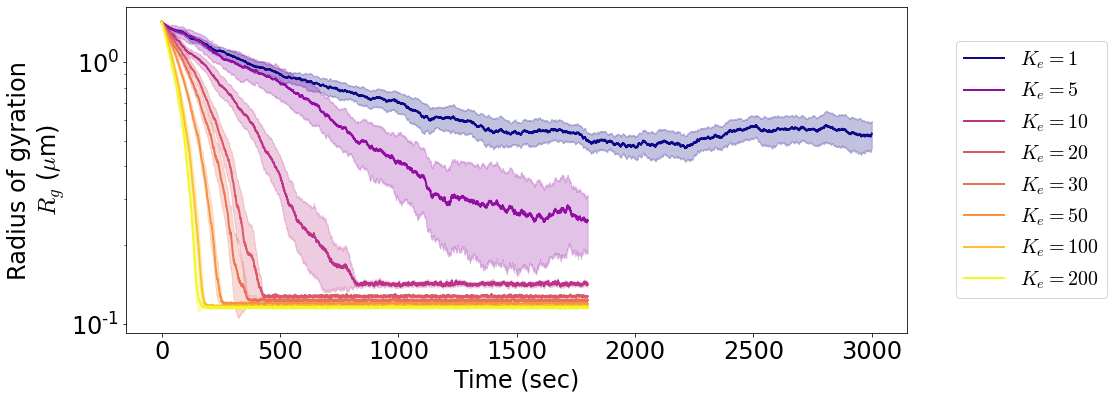

In [13]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

mp = re.compile('Ke(\d*\.?\d+)')

try:
    fig1, axarr1 = plt.subplots(figsize=(14, 6))

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            # _ = axarr1.plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$K_e = {label}$")
        ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xlim(-25, 1800)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

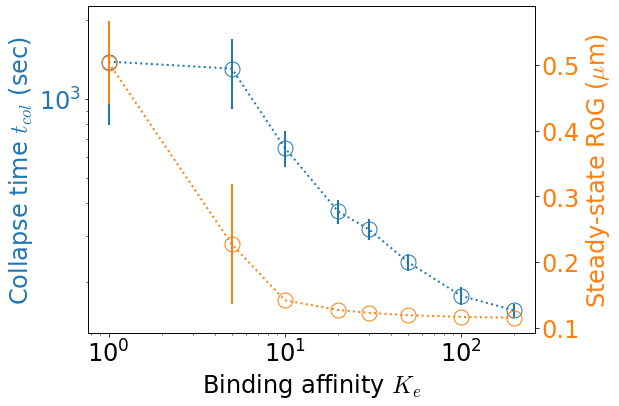

In [11]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
rog_avg_ind = -600
pval_start_ind = 0
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    axarr2 = axarr1.twinx()
    mp = re.compile('Ke(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = []
        rog_arr = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [rog_avg_ind, None])
            clps_times += [time_arr[clps_ind]]
            rog_arr += [rog[clps_ind:].mean()]

        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = axarr1.errorbar(pvals[pval_start_ind:], collapse_times_avg[pval_start_ind:], yerr=collapse_times_std[pval_start_ind:], color='tab:blue' , **marker_style)
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = axarr1.set_xlabel('Binding affinity $K_e$')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(100, 1500)
    _ = axarr1.tick_params(axis='y', labelcolor='tab:blue')

    _ = axarr2.errorbar(pvals[pval_start_ind:], rog_avg[pval_start_ind:], yerr=rog_std[pval_start_ind:], color='tab:orange', **marker_style)
    _ = axarr2.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')
    # _ = axarr2.set_ylim(.1, .15)
    _ = axarr2.tick_params(axis='y', labelcolor='tab:orange')


except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

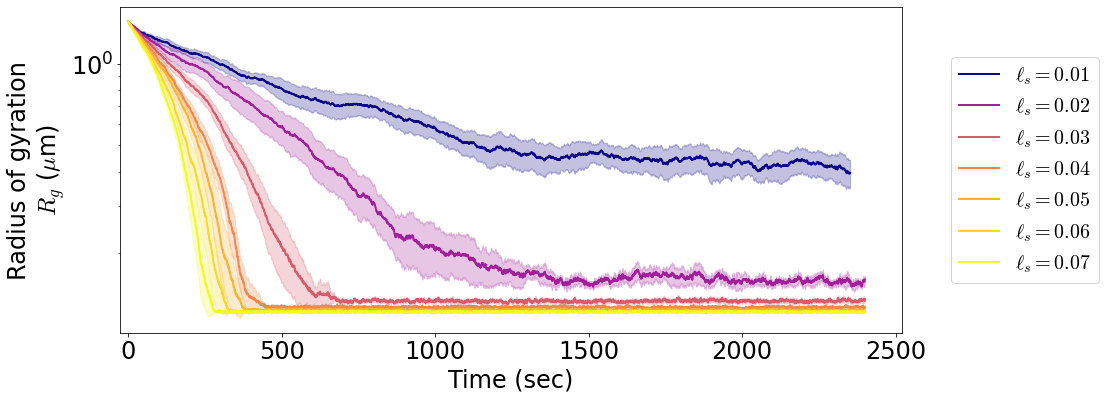

In [12]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

mp = re.compile('Ls(\d*\.?\d+)')

try:
    fig1, axarr1 = plt.subplots(figsize=(14, 6))

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        # sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            # _ = axarr1.plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$\ell_s = {label}$")
        ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xlim(-25)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]


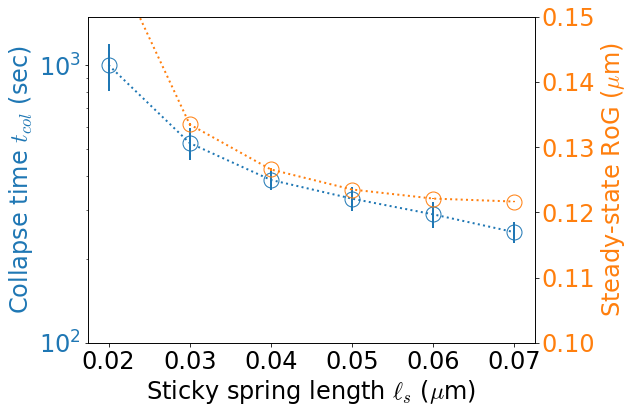

In [13]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
rog_avg_ind = -600
pval_start_ind = 1
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    axarr2 = axarr1.twinx()
    mp = re.compile('Ls(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = []
        rog_arr = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [rog_avg_ind, None])
            clps_times += [time_arr[clps_ind]]
            rog_arr += [rog[clps_ind:].mean()]

        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = axarr1.errorbar(pvals[pval_start_ind:], collapse_times_avg[pval_start_ind:], yerr=collapse_times_std[pval_start_ind:], color='tab:blue' , **marker_style)
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = axarr1.set_xlabel('Sticky spring length $\ell_s$ ($\mu$m)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(100, 1500)
    _ = axarr1.tick_params(axis='y', labelcolor='tab:blue')

    _ = axarr2.errorbar(pvals[pval_start_ind:], rog_avg[pval_start_ind:], yerr=rog_std[pval_start_ind:], color='tab:orange', **marker_style)
    _ = axarr2.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')
    _ = axarr2.set_ylim(.1, .15)
    _ = axarr2.tick_params(axis='y', labelcolor='tab:orange')


except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]


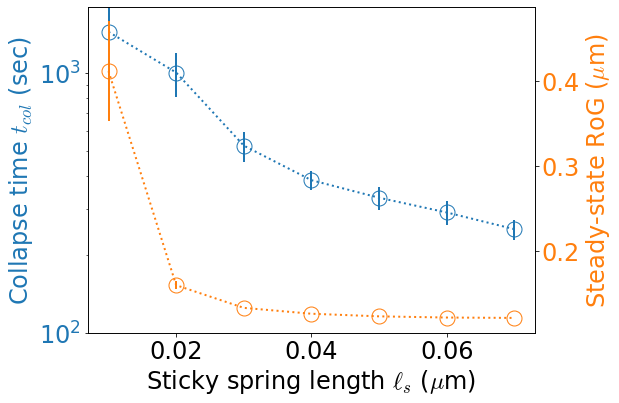

In [14]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
rog_avg_ind = -600
pval_start_ind = 0
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    axarr2 = axarr1.twinx()
    mp = re.compile('Ls(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = []
        rog_arr = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [rog_avg_ind, None])
            clps_times += [time_arr[clps_ind]]
            rog_arr += [rog[clps_ind:].mean()]

        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = axarr1.errorbar(pvals[pval_start_ind:], collapse_times_avg[pval_start_ind:], yerr=collapse_times_std[pval_start_ind:], color='tab:blue' , **marker_style)
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = axarr1.set_xlabel('Sticky spring length $\ell_s$ ($\mu$m)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(100, 1800)
    _ = axarr1.tick_params(axis='y', labelcolor='tab:blue')

    _ = axarr2.errorbar(pvals[pval_start_ind:], rog_avg[pval_start_ind:], yerr=rog_std[pval_start_ind:], color='tab:orange', **marker_style)
    _ = axarr2.tick_params(axis='y', labelcolor='tab:orange')
    _ = axarr2.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')


except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]


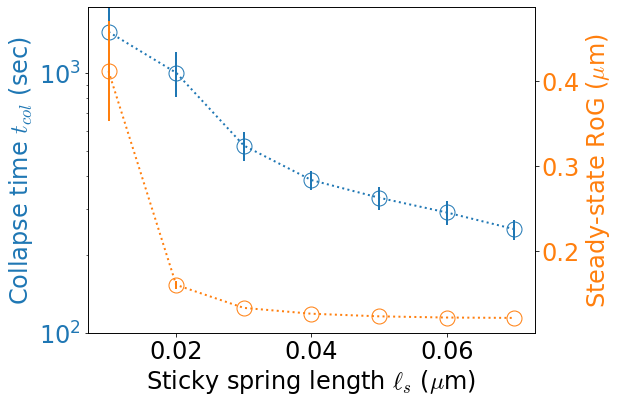

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
rog_avg_ind = -600
pval_start_ind = 0
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    axarr2 = axarr1.twinx()
    mp = re.compile('Ls(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = []
        rog_arr = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [rog_avg_ind, None])
            clps_times += [time_arr[clps_ind]]
            rog_arr += [rog[clps_ind:].mean()]

        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = axarr1.errorbar(pvals[pval_start_ind:], collapse_times_avg[pval_start_ind:], yerr=collapse_times_std[pval_start_ind:], color='tab:blue' , **marker_style)
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = axarr1.set_xlabel('Sticky spring length $\ell_s$ ($\mu$m)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(100, 1800)
    _ = axarr1.tick_params(axis='y', labelcolor='tab:blue')

    _ = axarr2.errorbar(pvals[pval_start_ind:], rog_avg[pval_start_ind:], yerr=rog_std[pval_start_ind:], color='tab:orange', **marker_style)
    _ = axarr2.tick_params(axis='y', labelcolor='tab:orange')
    _ = axarr2.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')


except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

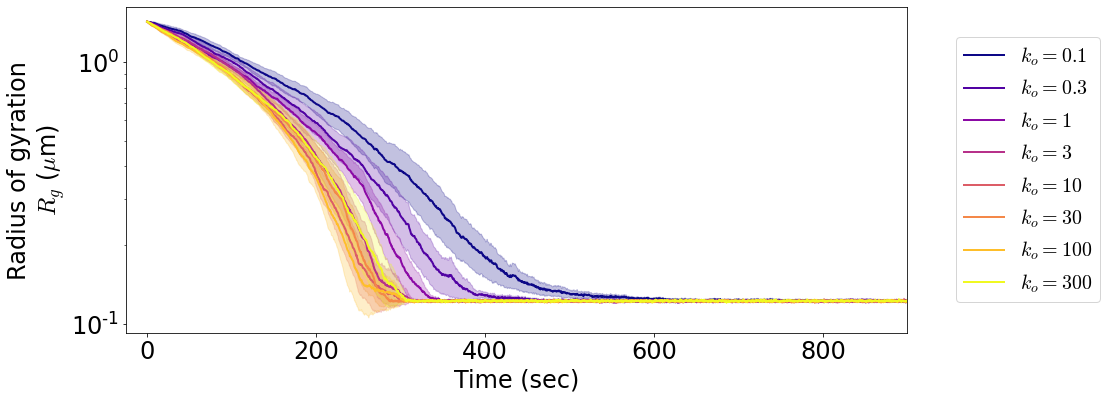

In [16]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = 1
# end_ind = -1600
end_ind = -1
start_bead = 0
end_bead = None

mp = re.compile('kod(\d*\.?\d+)')

try:
    fig1, axarr1 = plt.subplots(figsize=(14, 6))

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            avg_ee_arrs += [rog.tolist()]
            # _ = axarr1.plot(time_arr, rog, color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$")
        ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        # ci = std_ee_list[-1]
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xlim(-25, 900)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    # _ = axarr1.legend()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0]


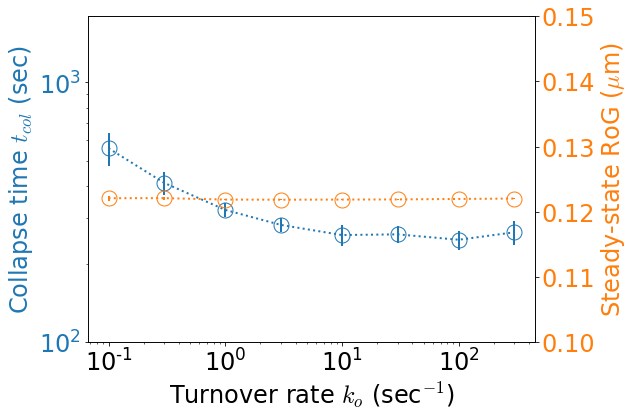

In [31]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
rog_avg_ind = -600
pval_start_ind = 0
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    axarr2 = axarr1.twinx()
    mp = re.compile('kod(\d*\.?\d+)')
    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = []
        rog_arr = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = find_steady_state_ind(rog, [rog_avg_ind, None])
            clps_times += [time_arr[clps_ind]]
            rog_arr += [rog[clps_ind:].mean()]

        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = axarr1.errorbar(pvals[pval_start_ind:], collapse_times_avg[pval_start_ind:], yerr=collapse_times_std[pval_start_ind:], color='tab:blue' , **marker_style)
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = axarr1.set_xlabel('Turnover rate $k_o$ (sec$^{-1}$)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(100, 1800)
    _ = axarr1.tick_params(axis='y', labelcolor='tab:blue')

    _ = axarr2.errorbar(pvals[pval_start_ind:], rog_avg[pval_start_ind:], yerr=rog_std[pval_start_ind:], color='tab:orange', **marker_style)
    _ = axarr2.set_ylim(.1, .15)
    _ = axarr2.tick_params(axis='y', labelcolor='tab:orange')
    _ = axarr2.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')


except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

# Conclusions and Next Steps

0.4772498680518208

In [51]:
erfinv(1/np.sqrt(2))

nan